In [2]:
import datetime
import gc
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg' 

from preprocessing import load_messages, translit

### Загузка и предварительная очитка данных 
Для исследования мы испоьзовали сведий дамп слака ODS от 06 марта 2021 года.<br>
Каналы jobs и jobs hr. Загрузим сообщения в pandas df и очистим от лишний информации.

In [3]:
messages = load_messages('jobs', 'jobs_hr')


Загружено 47767 cообщений
	Удалены технические сообщения: 6864 сообщений
	Дата и время округлены до секунд и переведены в datetime формат
	Текст приведен к маленьким буквам и очищен от лишних пробелов
Осталось 40903 cообщений


### Кол-во сообщений

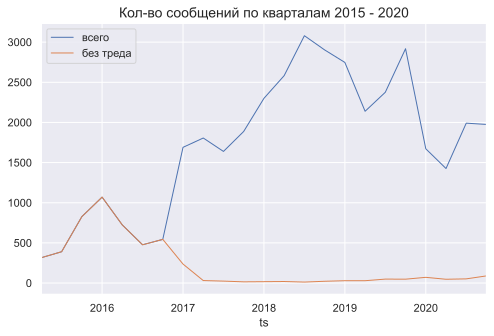

In [4]:
plt.figure(figsize = (8, 5))
messages[messages.ts.dt.year < 2021].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                 label='всего')
messages[(messages.thread_ts.isna()) & 
         (messages.ts.dt.year < 2021)].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                   label='без треда')
plt.legend()
plt.title('Кол-во сообщений по кварталам 2015 - 2020', size=14)
plt.show()

Общее кол-во сообщений достигло <b>максимума в 3 квартале 2018 года</b>.<br>
После этого активность снижалась - резкое <b>падение активности произошло в 2020 году</b>

#### Что это кронокризис или хайп по data science уже прошел?

Здесь мы смотрим на все сообщения - это и сами вакансии и комментарии пользователей.<br>
До 2017 года тредов вообще не было и все сообщения сыпались в общий канал.<br>
У части сообщений и сейчас нет треда - если никто не оставил комментарий.<br>

Для дальнейшего анализа нам нужно отделать сообщения с вакансиями от комментариев пользователей.<br>
Самый простой подход - это считать вакансией все сообщения с котрых начинается тред (thread_ts = ts).<br>
Но тогда мы потеряем всю статистику за 2015-2016 года.<p>
    
Второй вариант - это обучить простую модель на этой метке и разделить с ее помошбю сообщения без треда.<br>

### Классификация сообщений на вакансии и комментарии

В качесстве признаков будет использовать count по всем словам в сообщении.

In [5]:
# CountVectorizer для текста
countvectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)
countvectorizer.fit(messages['text'])
word_cols = countvectorizer.get_feature_names()
word_cols = ['_' + translit(col) + f'_{i}' for i, col in enumerate(word_cols)]

# Добавлеям колонки с count по словам
messages = pd.concat((messages, pd.DataFrame(countvectorizer.transform(messages['text']).toarray(), 
                                 columns=word_cols)), axis=1)

# Делим на трейн и тест и обучаем модель
df = messages[~messages['thread_ts'].isna()].reset_index(drop=True)
df['is_job'] = (df['thread_ts'] == df['ts']).astype('int8')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, word_cols], df['is_job'],
                                                    test_size = 0.33, random_state = 555)
gbm1 = lgb.LGBMClassifier(num_leaves=7, n_estimators=200, feature_fraction=0.3, bagging_fraction=0.5)
gbm1.fit(X_train, y_train)

# Помечяем вакансии новой моделью
messages['is_job'] = gbm1.predict(messages.loc[:, word_cols])
messages = messages.loc[:,[i for i in messages.columns if i not in word_cols]]

del X_train, y_train, df
gc.collect()

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


3914

#### Качество модели
<p>Качества этой простой модели более чем достаточно для поставленной задачи.<br>
Тем более, что разметка для обучения шумная и не на 100% точная.<p>

In [6]:
# Считаем метрики
accuracy_baseline = round(sum(y_test == 0) / len(y_test) * 100, 1)
print(f'Accuracy для наивной модели {accuracy_baseline}')
pred = gbm1.predict(X_test)
accuracy_model = round(sum(y_test == pred) / len(y_test) * 100, 1)
print(f'Accuracy для модели {accuracy_model}')
print(f'F1 score {f1_score(y_test, pred)}')

Accuracy для наивной модели 93.4
Accuracy для модели 99.6
F1 score 0.9666884389288046


#### Важность признаков
Вакансии и комментарии легко сплитятся по используемым словам.
Например на вакансию указывают такие слова: 
<li> навыки: python, sql, data, английский
<li> ссылки и email: http, https, mailto
<li> слова связанные с вилкой зп: вилка, от, fork, 200, 50 и т.д.
<li> другие слова часто встречаемые в описании вакансий: опыт, привет (в комментах люди редко здороваются), на, ищем, офис, москва, требования<p>
    
На комментарий указывают разговорные слова характерные для ответов:<br>
вот, просто, так, уже, есть, gt (использование цитаты)<p>

Ниже можно посомотреть top50 признаков из модели по версии shap

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


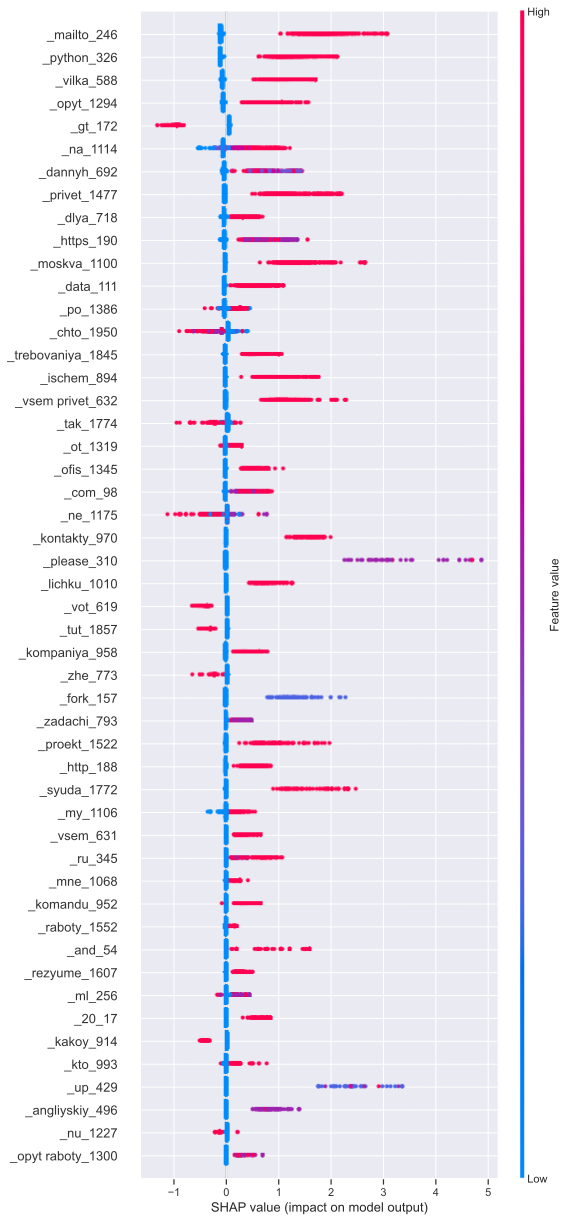

In [7]:
# Нарисуем шап для модели
explainer = shap.TreeExplainer(gbm1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=50)

### Кол-во сообщений с вакансиями

Теперь, с помощью нашей модели можно выделить только ваканси и посмотреть на их динамику<br>
Паника отменяется, товарищи, <b>кол-во вакнсий по прежнему растет!</b><br>
К концу 2020 года - было чуть меньше 100 вкансий в месяц, а за февраль 2021 уже почти 140!

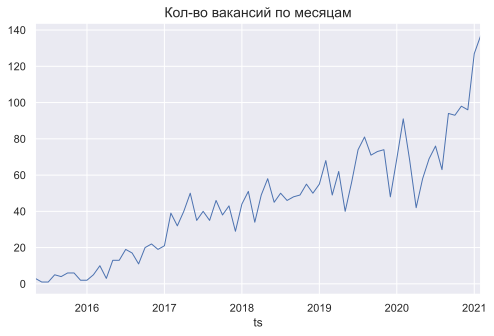

In [8]:
plt.figure(figsize = (8, 5))
messages[(messages.is_job==1) & 
         (messages.ts < '2021-03-01')].resample('M', on = 'ts')['ts'].count().plot(linewidth=1)
plt.title('Кол-во вакансий по месяцам', size=14)
plt.show()

### В какой месяц искать работу?

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
month = messages[(messages.is_job == 1) &
                 (messages.ts.dt.year > 2015) &
                 (messages.ts.dt.year < 2021)].resample('M', on = 'ts').agg({'ts': 'count'})  
month.columns = ['count']
month['month'] = month.index.month
month['order'] = [*range(1, len(month)+1)]
month = pd.concat([month, pd.get_dummies(month.month)], axis=1)
reg = LinearRegression()
cols =  [i for i in month.columns if i not in ['count', 'month']]
reg.fit(month.loc[:, cols], month['count'])
month['pred'] = reg.predict(month.loc[:, cols])

<AxesSubplot:xlabel='ts'>

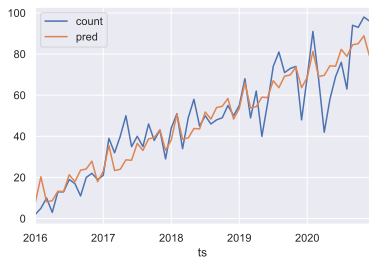

In [11]:
month.loc[:,['count', 'pred']].plot()

### Вспомогательные функции

In [12]:
# конвертация строки dataframe в dict

def convert_row_to_dict(row, columns):
    count = 1
    dictionary = {}
    dictionary['Index'] = row[0]
    for column in columns:
        dictionary[column] = row[count]
        count += 1
    return dictionary


# красиво вывести словарь

def print_dict(dictionary):
    for key, value in dictionary.items():
        print(key, ':', value)

# сортировка словаря по значениям ключей

def sort_dict_by_values(dictionary, reverse=True):
    return {key: value for key, value in sorted(dictionary.items(), reverse=reverse, key=lambda item: item[1])}

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict

In [14]:
def build_histogram_by_keywords(texts, dictionary, dictionary_mapping, color='gold'):
    for text in texts:
        for key in dictionary.keys():
            key_variations = dictionary_mapping[key]
            for key_variation in key_variations:
                if key_variation in text.lower():
                    dictionary[key] += 1
                    break
                    
    sorted_dictionary = {key: value for key, value in sorted(dictionary.items(), reverse=True, key=lambda item: item[1])}
    print(sorted_dictionary)
    
    plt.figure(figsize=(3 + len(dictionary.keys()), 5))
    plt.bar(sorted_dictionary.keys(), sorted_dictionary.values(), color=color)
    plt.show()

### Вспомогательные методы

In [15]:
# добавление года

def add_year_column(messages):
    years = []
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        year = row_dict['ts'].year
        years.append(year)
    messages['year'] = years
    
    
add_year_column(messages)

In [16]:
# добавление новых признаков по регулярным выражениям, найденным в тексте

import re

def add_feature(messages, feature_name, feature_regexs):
    labels = []
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        text = row_dict['text']
        regex_found = False
        for feature_regex in feature_regexs:
            if re.search(r'{}'.format(feature_regex), text):
                regex_found = True
                break
        labels.append(regex_found)
    messages[feature_name] = labels

In [17]:
# построение гистограммы по распределению

def build_hist_from_distribution(distribution, years, title='', xlabel='', ylabel=''):
    colors=['gold', 'deepskyblue', 'greenyellow', 'orangered', 'blueviolet', 'lightgray']
    n = len(distribution.keys())
    i = 0
    coef = 0.8
    width = coef / n
    plt.figure(figsize=(2 * n, 7))
    for key, technology in distribution.items():
        color = 'lightgray' if key == 'else' else colors[i]
        plt.bar(np.array(years) + width * (i + 0.5 * (1 - n)), technology.values(),
                label=key, width=width, color=color)
        i += 1
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [18]:
# получение распределения значений признаков по годам

def get_distribution_by_years(messages, features, years, ds_jobs_distribution=False):
    distribution = {
        feature: {
            year: 0 for year in years
        } for feature in features
    }
    distribution['else'] = {
        year: 0 for year in years
    }
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        year = row_dict['ts'].year
        if year not in years or (ds_jobs_distribution and not row_dict['data_scientist']):
            continue
        feature_was_found = False
        for feature in features:
            if row_dict[feature]:
                distribution[feature][year] += 1
                feature_was_found = True
        if not feature_was_found:
            distribution['else'][year] += 1
    return distribution

### Анализ вакансий

In [19]:
levels_dict = {
    'intern': ['intern', 'стажер', 'стажёр', 'стажировк'],
    'junior': ['junior', 'джун', 'начинающ'],
    'middle': ['middle', 'мидл', 'миддл'],
    'senior': ['senior', 'синьор', 'сеньор', 'старш'],
    'lead': ['lead', 'head', 'лид', 'ведущ']
}

dl_frameworks_dict = {
    'pytorch': ['pytorch'],
    'tensorflow': ['tensorflow', 'tf'],
    'keras': ['keras']
}

jobs_dict = {
    'data_scientist': [' ds ', 'data science', 'data scientist', 'дата саенс', 'дата саентист'],
    'data_engineer': [' de ', 'data engineer', 'дата инженер'],
    'data_analyst': [' da ', 'data analyst', 'data analytic', 'аналитик']
}

ds_jobs_dict = {
    'computer_vision': [' cv ', 'computer vision', 'компьютерное зрение', 'компьютерным зрением'],
    'deep_learning': [' dl ', 'deep learning', 'глубокое обучение', 'глубоким обучением', 'глубокого обучения'],
    'nlp': [' nlp ', 'natural language processing', 'обработка естественного языка', 'обработкой естественного языка']
}

dicts = [levels_dict, dl_frameworks_dict, jobs_dict, ds_jobs_dict]
for dict_ in dicts:
    for feature_name, feature_regexs in dict_.items():
        add_feature(messages, feature_name, feature_regexs)

### Анализ текстов вакансий

In [20]:
years = range(2016, 2022)
job_messages = messages[(messages.is_job == 1) & (messages.ts < '2021-03-01')]

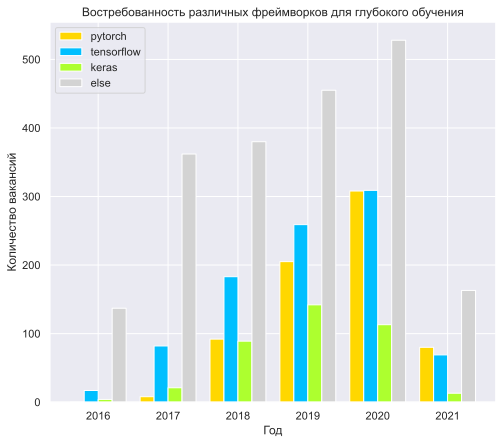

pytorch : {2016: 0, 2017: 8, 2018: 92, 2019: 205, 2020: 308, 2021: 80}
tensorflow : {2016: 17, 2017: 82, 2018: 183, 2019: 259, 2020: 309, 2021: 69}
keras : {2016: 4, 2017: 21, 2018: 89, 2019: 142, 2020: 113, 2021: 13}
else : {2016: 137, 2017: 362, 2018: 380, 2019: 455, 2020: 528, 2021: 163}


In [21]:
features = dl_frameworks_dict.keys()
distribution = get_distribution_by_years(job_messages, features, years)
build_hist_from_distribution(distribution, years,
                             title='Востребованность различных фреймворков для глубокого обучения',
                             xlabel='Год',
                             ylabel='Количество вакансий')
print_dict(distribution)

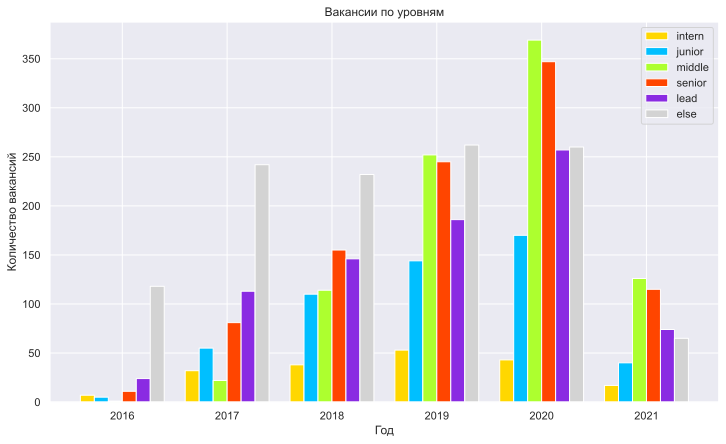

intern : {2016: 7, 2017: 32, 2018: 38, 2019: 53, 2020: 43, 2021: 17}
junior : {2016: 5, 2017: 55, 2018: 110, 2019: 144, 2020: 170, 2021: 40}
middle : {2016: 1, 2017: 22, 2018: 114, 2019: 252, 2020: 369, 2021: 126}
senior : {2016: 11, 2017: 81, 2018: 155, 2019: 245, 2020: 347, 2021: 115}
lead : {2016: 24, 2017: 113, 2018: 146, 2019: 186, 2020: 257, 2021: 74}
else : {2016: 118, 2017: 242, 2018: 232, 2019: 262, 2020: 260, 2021: 65}


In [22]:
features = levels_dict.keys()
distribution = get_distribution_by_years(job_messages, features, years)
build_hist_from_distribution(distribution, years,
                             title='Вакансии по уровням',
                             xlabel='Год',
                             ylabel='Количество вакансий')
print_dict(distribution)

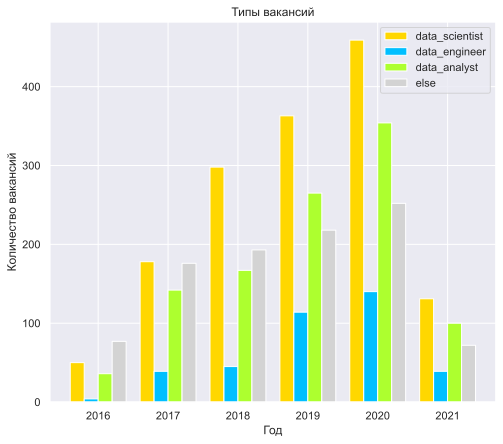

data_scientist : {2016: 50, 2017: 178, 2018: 298, 2019: 363, 2020: 459, 2021: 131}
data_engineer : {2016: 4, 2017: 39, 2018: 45, 2019: 114, 2020: 140, 2021: 39}
data_analyst : {2016: 36, 2017: 142, 2018: 167, 2019: 265, 2020: 354, 2021: 100}
else : {2016: 77, 2017: 176, 2018: 193, 2019: 218, 2020: 252, 2021: 72}


In [23]:
features = jobs_dict.keys()
distribution = get_distribution_by_years(job_messages, features, years)
build_hist_from_distribution(distribution, years,
                             title='Типы вакансий',
                             xlabel='Год',
                             ylabel='Количество вакансий')
print_dict(distribution)

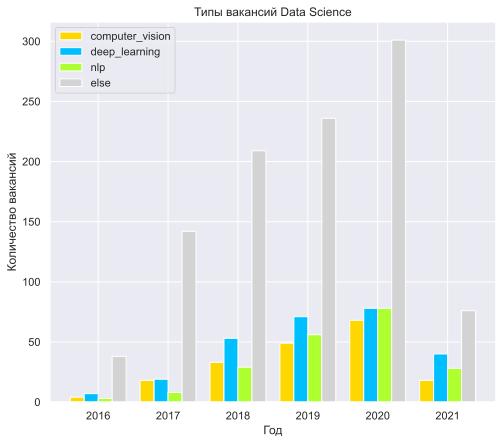

computer_vision : {2016: 4, 2017: 18, 2018: 33, 2019: 49, 2020: 68, 2021: 18}
deep_learning : {2016: 7, 2017: 19, 2018: 53, 2019: 71, 2020: 78, 2021: 40}
nlp : {2016: 3, 2017: 8, 2018: 29, 2019: 56, 2020: 78, 2021: 28}
else : {2016: 38, 2017: 142, 2018: 209, 2019: 236, 2020: 301, 2021: 76}


In [24]:
features = ds_jobs_dict.keys()
distribution = get_distribution_by_years(job_messages, features, years, ds_jobs_distribution=True)
build_hist_from_distribution(distribution, years,
                             title='Типы вакансий Data Science',
                             xlabel='Год',
                             ylabel='Количество вакансий')
print_dict(distribution)

## Анализ эмоций к вакансиям

In [25]:
from collections import defaultdict

In [26]:
reactions_dict = defaultdict(lambda: 0)
df = messages[messages['is_job'] == 1]
for _, message in df.iterrows():
    reactions = message['reactions']
    if isinstance(reactions, list):
        for reaction in reactions:
            name = reaction['name']
            count = reaction['count']
            reactions_dict[name] += count
sorted_reactions_dict = {key: value for key, value in sorted(reactions_dict.items(), reverse=True, key=lambda item: item[1])}
for key, value in sorted_reactions_dict.items():
    print(key, ':', value)

# len(reactions)

reactions_dict = {
    'ramen': -1, # лапша
    '+1': 1,
    'fireball': 1,
    'ban': -1,
    'notbad': 1,
    'venhead': 1, # бабушкин
    'fork': 1, # вилка не указана
    'fire': 1,
    'galera': 1, # outsource-компании
    'widefork': 1,
    'moneys': 1,
    'no-junior': 1,
    'naebalovo': -1
}

ramen : 21164
+1 : 18268
fireball : 10397
ban : 9471
notbad : 9134
fork : 8409
fire : 6920
galera : 6302
widefork : 4805
sberbank : 4057
venheads : 3759
putin : 2557
el_risitas : 2557
moneys : 2498
no_capitalism : 2305
rowing-galera : 2198
eww : 1854
hankey : 1647
+1::skin-tone-2 : 1522
noexcel : 1419
el_resitas_shake : 1305
x5 : 1287
elite-only : 1134
facepalm : 1118
spb : 1079
putout : 1074
tinkoff : 1031
no-junior : 962
astanavites : 917
rospil : 916
petr-west : 862
nor : 860
yandex : 845
joy : 803
moneybag : 800
chains : 781
sber_new : 672
zhyvebelarus : 666
ico : 621
wat : 617
grammar : 595
moneyparrot : 573
flag-ua : 572
harold : 563
holypeka : 562
gref : 552
el_resitas_shake2 : 552
bigbrother : 549
flag-by : 525
r : 511
mickey : 500
flag-by2 : 499
muscle : 483
100rub : 430
printing-money : 430
money_mouth_face : 421
heavy_plus_sign : 411
ozon : 392
mipt : 388
+1::skin-tone-6 : 377
are_you_fucking_kidding_me : 360
mts : 352
catshake : 347
noise : 345
belarustrueparrot : 341
airpl

alenka : 8
neuralnet : 8
dancer::skin-tone-2 : 8
flag-es : 8
dr_evil : 8
alarm_clock : 8
malev : 8
milky_way : 8
masha : 8
smirk_cat : 8
simple_smile : 8
mosque : 8
arrow_up : 8
here_we_go_again : 8
hotsprings : 8
dobry_vzglyad : 8
man-getting-haircut::skin-tone-2 : 8
blowfish : 8
earth_americas : 8
badpokerface : 8
eralash : 8
cookie : 8
cat2 : 7
grinning : 7
discoparrot : 7
movie_camera : 7
azure : 7
spock-hand : 7
put_litter_in_its_place : 7
censoredparrot : 7
-1::skin-tone-5 : 7
disappointed : 7
true-story : 7
pedobir : 7
zero : 7
sleuth_or_spy : 7
high_brightness : 7
scream_cat : 7
el_resitas_cat : 7
airplane_arriving : 7
couch_and_lamp : 7
eagle : 7
violin : 7
loveparrot : 7
older_woman::skin-tone-6 : 7
pi : 7
goose : 7
skull : 7
flag-ci : 7
again-shocked : 7
ice_cream_parrot : 7
nyancat : 7
300 : 7
shiza : 7
man-lifting-weights : 7
cake : 7
dog-gay : 7
flag-cv : 7
dizzy : 7
chocolate_bar : 7
noputinism : 7
shutupandxgboost : 6
amaze : 6
loud_sound : 6
its_ok_bro : 6
performing_a

In [27]:
df = pd.read_csv('processed_data/salaries_parsed_2017_06_01.csv')

In [28]:
df

,text,ts,salary,salary_2,is_eng,currency,forks,is_gross
0,тиньков ищет data scientist'a: <http://hh.ru/v...,2015-04-14 14:20:20,NaN,NaN,1,NaN,NaN,1
1,"коллеги, мне тут упало такое предложение. я сл...",2015-05-18 11:50:58,NaN,NaN,0,NaN,NaN,1
2,всем привет! есть предложение о работе в сфере...,2015-05-19 15:59:07,NaN,NaN,0,NaN,NaN,1
3,<@u06k9elb1>: добро пожаловать в этот slack ев...,2015-06-20 18:12:08,"условия:\n- 50,000 рублей в месяц на время ста...",NaN,0,rub,NaN,0
4,руководитель проектов / эксперт (data monetiza...,2015-07-13 15:38:58,NaN,NaN,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...
3151,"друзья, коллеги и вновь, здравствуйте!\n\nянде...",2021-02-18 10:22:55,зп: 150-300 k (финальные цифры по итогам собес...,зп: 150-300 k (финальные цифры по итогам собес...,0,rub,"[[150.0, 300.0]]",0
3152,- вакансия: head of data engineering\nгород: м...,2021-03-01 14:00:10,зп: 250-400 к (финальные цифры по итогам собес...,зп: 250-400 к (финальные цифры по итогам собес...,0,rub,"[[250.0, 400.0]]",0
3153,"*clickio*, международная it-компания, ищет *ст...",2021-03-01 14:22:40,условия:*\n100 000 до 120 000 рублей на руки,100 000 до 120 000 рублей на руки,0,rub,"[[100.0, 120.0]]",0
3154,компания: :sber_new:*сбербанк*\nгород: москва ...,2021-03-01 18:22:23,вилка:*150 000 – 250 000*руб/мес,вилка:*150 000 – 250 000*руб/мес,0,rub,"[[150.0, 250.0]]",0


In [29]:
dicts = [levels_dict, dl_frameworks_dict, jobs_dict, ds_jobs_dict]
for dict_ in dicts:
    for feature_name, feature_regexs in dict_.items():
        add_feature(df, feature_name, feature_regexs)

In [64]:
def isNaN(var):
    return isinstance(var, float) and var != var


def extract_all_numbers_from_string(s):
    return [float(number) for number in re.findall(r"[-+]?\d*\.\d+|\d+", s)]


def convert_list_to_list_of_pairs(lst):
    return list(zip(*[iter(lst)]*2))


def determine_level_rub(avg):
    if 30 <= avg < 60:
        return 'intern'
    elif 60 <= avg < 100:
        return 'junior'
    elif 100 <= avg < 180:
        return 'middle'
    elif 180 <= avg < 270:
        return 'senior'
    elif 270 <= avg:
        return 'lead'


def determine_level(fork, currency):
    a, b = int(fork[0]), int(fork[1])
    if a > b:
        return None
    if currency == 'rub':
        if a >= 1000:
            a /= 1000
        if b >= 1000:
            b /= 1000
        avg = (a + b) / 2
        return determine_level_rub(avg)
    

def determine_levels(row_dict):
    levels = {
        level: False for level in levels_dict.keys()
    }
    currency = row_dict['currency']
    forks = row_dict['forks']
    
    if isNaN(forks) or isNaN(currency):
        return levels
    
    forks_list = extract_all_numbers_from_string(forks)
    if len(forks_list) % 2 == 1:
        levels[determine_level_rub(sum(forks_list) / len(forks_list))] = True
    else:
        forks_list = convert_list_to_list_of_pairs(forks_list)
        for fork in forks_list:
            level = determine_level(fork, currency)
            if level is not None:
                levels[level] = True
    return levels


def fill_up_job_levels(messages):
    levels_found = []
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        levels = levels_dict.keys()
        level_found = False
        for level in levels:
            if row_dict[level]:
                level_found = True
                break
        if not level_found:
            determined_levels = determine_levels(row_dict)
            for determined_level in determined_levels.keys():
                if determined_levels[determined_level]:
                    messages[determined_level] = True 
        levels_found.append(level_found)
    messages['level_found'] = levels_found
    

def find_average_salaries(messages):
    average_salaries = {
        level: {
            'count': 0,
            'sum': 0,
            'low': 0,
            'high': 0
        } for level in levels_dict.keys()
    }
    
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        forks_str = row_dict['forks']
        currency = row_dict['currency']
        if isNaN(forks_str) or isNaN(currency) or currency != 'rub':
            continue
            
        salary_numbers = extract_all_numbers_from_string(forks_str)
        salary_numbers = list(map(lambda x: x / 1000 if x >= 1000 else x, salary_numbers))
        
        if len(salary_numbers) == 0:
            continue
            
        if len(salary_numbers) % 2 == 1:
            sum_ = low = high = sum(salary_numbers) / len(salary_numbers)
            count = 1
            
        else:
            forks_list = convert_list_to_list_of_pairs(salary_numbers)
            count = sum_ = low = high = 0
            for fork in forks_list:
                count += 1
                low += fork[0]
                high += fork[1]
                sum_ += (low + high) / 2
                
        for level in levels_dict.keys():
            if row_dict[level]:
                average_salaries[level]['count'] += 1
                average_salaries[level]['sum'] += sum_ / count
                average_salaries[level]['low'] += low / count
                average_salaries[level]['high'] += high / count
            
    for level in average_salaries.keys():
        count = average_salaries[level]['count']
        average_salaries[level]['sum'] /= count
        average_salaries[level]['low'] /= count
        average_salaries[level]['high'] /= count
    
    return average_salaries


fill_up_job_levels(df)
# average_salaries = find_average_salaries(df)
# print_dict(average_salaries)

"""
intern: 40-60
junior: 50-100
middle: 120-200
senior: 150-300
lead: 300-500
head: 500+
"""

'\nintern: 40-60\njunior: 50-100\nmiddle: 120-200\nsenior: 150-300\nlead: 300-500\nhead: 500+\n'

In [81]:
# !level_found and forks != NaN -> 951
# !level_found and currency != NaN -> 912
pd.set_option('display.max_rows', 4000)
df[['intern', 'junior', 'middle', 'senior', 'lead', 'forks', 'level_found', 'ts']]
# df

,intern,junior,middle,senior,lead,forks,level_found,ts
0,False,False,True,False,False,NaN,False,2015-04-14 14:20:20
1,False,False,True,False,False,NaN,False,2015-05-18 11:50:58
2,False,True,True,False,False,NaN,True,2015-05-19 15:59:07
3,True,False,True,True,False,NaN,True,2015-06-20 18:12:08
4,False,False,True,False,False,NaN,False,2015-07-13 15:38:58
5,False,False,True,False,False,NaN,False,2015-07-28 10:19:51
6,False,False,True,False,True,NaN,True,2015-08-18 15:32:46
7,False,False,True,True,True,NaN,True,2015-08-20 13:50:54
8,False,False,True,False,False,NaN,False,2015-09-02 13:01:48
9,False,False,True,False,False,NaN,False,2015-09-10 15:32:12


In [39]:
a = [1, 2, 3, 4, 5, 6, 7, 8]
b = list(zip(*[iter(a)]*2))
print(b)

[(1, 2), (3, 4), (5, 6), (7, 8)]


In [67]:
df

,text,ts,salary,salary_2,is_eng,currency,forks,is_gross,intern,junior,...,pytorch,tensorflow,keras,data_scientist,data_engineer,data_analyst,computer_vision,deep_learning,nlp,level_found
0,тиньков ищет data scientist'a: <http://hh.ru/v...,2015-04-14 14:20:20,NaN,NaN,1,NaN,NaN,1,False,False,...,False,False,False,True,False,False,False,False,False,False
1,"коллеги, мне тут упало такое предложение. я сл...",2015-05-18 11:50:58,NaN,NaN,0,NaN,NaN,1,False,False,...,False,False,False,False,False,False,False,False,False,False
2,всем привет! есть предложение о работе в сфере...,2015-05-19 15:59:07,NaN,NaN,0,NaN,NaN,1,False,True,...,False,False,False,False,False,False,False,False,False,True
3,<@u06k9elb1>: добро пожаловать в этот slack ев...,2015-06-20 18:12:08,"условия:\n- 50,000 рублей в месяц на время ста...",NaN,0,rub,NaN,0,True,False,...,False,False,False,False,False,False,False,False,False,True
4,руководитель проектов / эксперт (data monetiza...,2015-07-13 15:38:58,NaN,NaN,0,NaN,NaN,1,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,"друзья, коллеги и вновь, здравствуйте!\n\nянде...",2021-02-18 10:22:55,зп: 150-300 k (финальные цифры по итогам собес...,зп: 150-300 k (финальные цифры по итогам собес...,0,rub,"[[150.0, 300.0]]",0,False,False,...,False,False,False,False,False,True,False,False,False,True
3152,- вакансия: head of data engineering\nгород: м...,2021-03-01 14:00:10,зп: 250-400 к (финальные цифры по итогам собес...,зп: 250-400 к (финальные цифры по итогам собес...,0,rub,"[[250.0, 400.0]]",0,False,False,...,False,False,False,False,True,True,False,False,False,True
3153,"*clickio*, международная it-компания, ищет *ст...",2021-03-01 14:22:40,условия:*\n100 000 до 120 000 рублей на руки,100 000 до 120 000 рублей на руки,0,rub,"[[100.0, 120.0]]",0,False,False,...,False,False,False,False,False,True,False,False,False,True
3154,компания: :sber_new:*сбербанк*\nгород: москва ...,2021-03-01 18:22:23,вилка:*150 000 – 250 000*руб/мес,вилка:*150 000 – 250 000*руб/мес,0,rub,"[[150.0, 250.0]]",0,False,False,...,True,True,True,True,False,False,False,True,True,True
